# Описание подхода для классификации научных статей (команда 17)

## Основные шаги

1.  Подготовка данных
2.  Выбор числа кластеров
3.  Обучение модели KMeans
4.  Статистический и визуальный анализ выделенных кластеров 
5.  Разметка данных и отбор эталонных объектов в кластерах
6.  Обучение моделей классификации научных статей.Тестирование моделей и оценка на неэталонных объектах
7.  Выделение тэгов в классах


## Подготовка данных

На основе проведенного ранее EDA было выявлено, что только 80% статей имеют поле 'abstract'. Кроме того было принято решение, что для обучения будут выбраны только статьи не старше 1990 года и имеющие по крайней мере 2 цитирования. 

In [ ]:
import io
import os
import numpy as np
import pandas as pd
import json
import dask
import dask.dataframe as dd
from dask.distributed import progress
from dask.diagnostics import ProgressBar


In [ ]:
!unzip /content/drive/MyDrive/MADE/data/new_dblpv13.zip

Archive:  /content/drive/MyDrive/MADE/data/new_dblpv13.zip
  inflating: new_dblpv13.jsonl       


In [ ]:
path = '/content/new_dblpv13.jsonl'

df = dd.read_json(path, encoding = "utf-8", blocksize = 128 * 1024 * 1024)  # 256 MB 

In [ ]:
df = df[(df['lang'] == 'en')&(df['n_citation'] > 2)&(df['year'] > 1990)]
df_cut = df.drop(['page_start', 'page_end', 'volume', 'issue', 'issn',
       'isbn', 'pdf', 'url', 'venue', 'keywords', 'n_citation', 'lang','fos', 'year', 'authors', 'doi', 'references'], axis = 1)
df_cut.columns

Index(['_id', 'abstract', 'title'], dtype='object')

После отбора статей мы оставили только поля необходимые для кластеризации. Также для уменьшения времени обучения моделей мы взяли случайную подвыборку из 30% статей.

In [ ]:
df_cut = df_cut.dropna(subset = ['abstract'])
df_cut = df_cut[df_cut['abstract'] != '']
df_cut.drop_duplicates(inplace = True)
df_cut['description'] = df_cut['title'] + df_cut['abstract']
df_cut = df_cut.drop(labels = ['title', 'abstract'], axis =1).sample(frac=0.3,random_state=1)
df_cut.head()


,_id,description
4,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...
11,53e99784b7602d9701f3eaf6,1There is a growing interest in the potential ...
17,53e99784b7602d9701f3f0b9,"7373170279850We conjecture that 7,373,170,279,..."
19,53e99784b7602d9701f3f8c2,Foreword.Pattern finding in biomolecular data ...
27,53e99784b7602d9701f3f411,Using XML to Integrate Existing Software Syste...


Далее мы делаем предобработку текста для построения векторов статей

In [ ]:
!pip install textsearch
!pip install contractions
!pip install sister

In [ ]:
#remove noise form text 
import re
import contractions
from contractions import contractions_dict
import nltk
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')


def remove_noise(text):

    text = re.sub(r",", "", text)
    text = re.sub(r"\w+\d+", " ", text)
    text = re.sub(r'\d+'," ", text)
    text = re.sub(r"\$", "dollar ", text)
    text = re.sub(r"\$+", "dollar ", text)
    text = re.sub(r"dollars", "dollar", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r":", "", text)
    text = re.sub(r" :", "", text)
    text = re.sub(r"\w+\-\w+", "", text)
    text = re.sub(r" -", "", text)
    text = re.sub(r" s ", "", text)
    text = re.sub(r" - ", "", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    #text = re.sub(r",", "", text)
    #text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"", "", text)
    return text
    
    
def remove_noise2(text):
    text = text.replace(".", "")
    return text
    
def expand_contractions(text):
    
    return contractions.fix(text)
    
#remove stopwords
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
def remove_stopwords3(text):
    tokens = nltk.word_tokenize(text)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop_words]
    
    return " ".join(filtered_words)

def build_emb(text):
    return bert_embedding(text)

def clean_text(df):
    df['description'] = df.description.map(lambda description:description.lower()).map(remove_noise).map(expand_contractions).map(remove_noise2).map(remove_stopwords3)
      
    return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Для построения векторов мы используем библиотеку sister, в которой уже реализованы предобученные языковые модели. Полученные веторные представления статей сохраняются вмести с айдишниками для последующей загрузки в модели.

In [ ]:
import sister
embedding = sister.MeanEmbedding(lang="en")
vectors = df_cut.map_partitions(clean_text, meta = df_cut)
embed_vec = embedding(vectors.description)


Loading model...


## Выбор числа кластеров

Для выбора числа кластеров мы использовали модель  KMeans. Мы обучали эту модель на разном числе кластеров  от 10 до 100 и сравнивали величину инерции (кластерная сумма квадратов расстояний). Из таблицы видно, что с увеличением числа кластеров инерция уменьшается, однако это уменьшение не существенно. Мы проанализировали более детатьно интервал от 15 до 20 кластеров и статистику распределения данных по кластерам и пришли к выводу, что 20 - это оптимальное число кластеров.

    k_cluster     inertia

    10	      248798.7033
    15	      243758.1341
    20	      241760.761
    25	      239534.7238
    30	      238360.654
    40	      235783.3372
    50	      234407.5351
    60	      232576.6499
    70	      231571.2057
    80	      230179.7271
    90	      229214.329


## Обучение модели KMeans

Для задачи кластеризации мы выбрали модель KMeans, так как этот метод является самым быстрым при кластеризации объемах свыше 100 000 точек, даже по сравнению с HDBSCAN (смотри документацию https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html). Кроме того эта модель реализована в библиотеке Dask, которую мы используем.

Для начала сохраненные эмбэдинги мы преобразуем в pandas, где каждый столбец соответствует одному элементу вектора.

In [ ]:
pand_df = pd.DataFrame(columns = [str(i) for i in range(300)])
for i, el in enumerate(embed_vec.partitions):
    a = pd.DataFrame(el.compute()['embedding'].to_list(), columns=[str(i) for i in range(300)])
    pand_df = pand_df.append(a, ignore_index=True)
    

In [ ]:
from dask_ml.cluster import KMeans, SpectralClustering
def func(n):
  return KMeans(n_clusters = n, oversampling_factor = 2, random_state=1)#SpectralClustering(n_clusters = n)

with ProgressBar():
  #data = new_df['description'].to_dask_array(lengths=True)
  for n_clusters in range(20, 21, 1):
    km = func(n_clusters)
    km.fit(pand_df)#new_df['description'])
    inert.append((n_clusters, km.inertia_))
    print(n_clusters, km.inertia_)
  
  predictions = km.predict(pand_df)

##  Статистический и визуальный анализ выделенных кластеров 

После обучения модели кластеризации, мы можем проанализировать число статей в каждом кластере.

count       20.000000
mean     31195.300000
std      13009.390698
min        967.000000
25%      27261.750000
50%      33013.500000
75%      37367.250000
max      54993.000000
Name: 0, dtype: float64


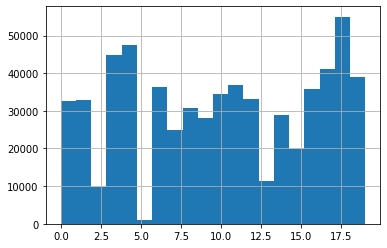

In [ ]:
n_cluster = 20 
pand_df['n_cluster'] = predictions
stat = pand_df.groupby(['n_cluster']).count()
print(stat.iloc[:, 0].describe())
pand_df['n_cluster'].hist(bins = n_cluster)


Из статистики видно, что  есть один маленький кластер и возможно его следует объединить с каким-то другим кластером. Для того чтобы принять решение нужно посмотреть как центры кластеров расположены относительно друг друга. На графики видно, что центр самого маленького кластера расположен на наибольшем расстоянии от всех остальных центроидов, поэтому его нельзя объединять с другими кластерами.

(300,) (300,) (300,)
(20, 3)
10
10
10
Explained variation per principal component: [0.68046397 0.10629596 0.06653229]


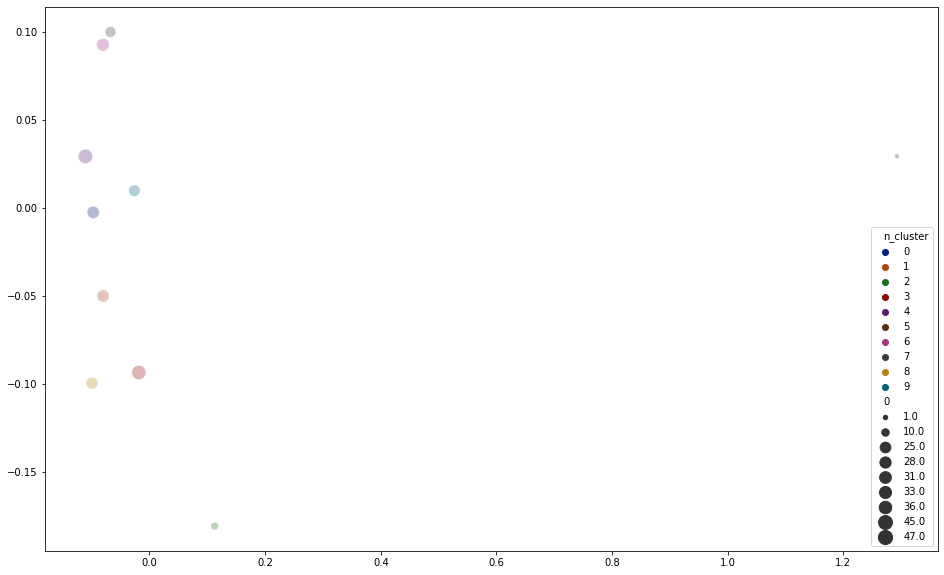

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

pca = PCA(n_components=3)

X = km.cluster_centers_
pca_result = pca.fit_transform(X)

X_pca = []
for i in range(3):
  X_pca.append(pca_result[:10,i])
  print(len(X_pca[i]))
 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=X_pca[0], y=X_pca[2],
    size = round(0.001 * stat.iloc[:10, 0]),
    hue=stat.index[:10],
    palette=sns.color_palette('dark'),
    sizes=(20, 200),
   # data= (),
    legend="full",
    alpha=0.3
)

Изобразим сами кластеры.

In [ ]:
pca = PCA(n_components=10)

X = pand_df.drop(labels = ['n_cluster'], axis= 1)

pca_result = pca.fit_transform(X)

X_pca = []
for i in range(10):
  X_pca.append(pca_result[:,i])
 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.07887371 0.06784496 0.04991798 0.03865681 0.03473312 0.02649908
 0.02313298 0.02117373 0.01856337 0.01744276]


/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


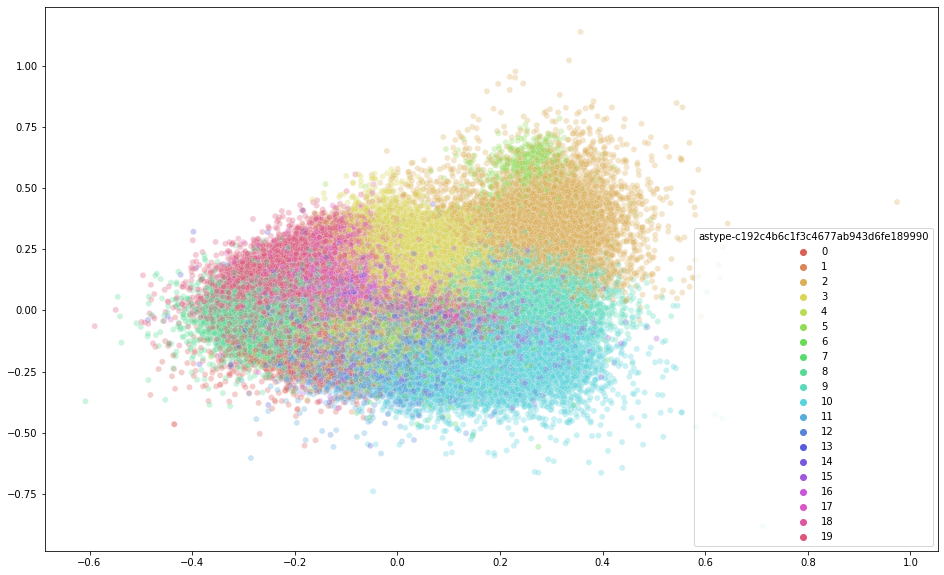

In [ ]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=X_pca[0], y=X_pca[1],
    hue=predictions,
    palette=sns.color_palette("hls", 20),
   # data= (),
    legend="full",
    alpha=0.3
)

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


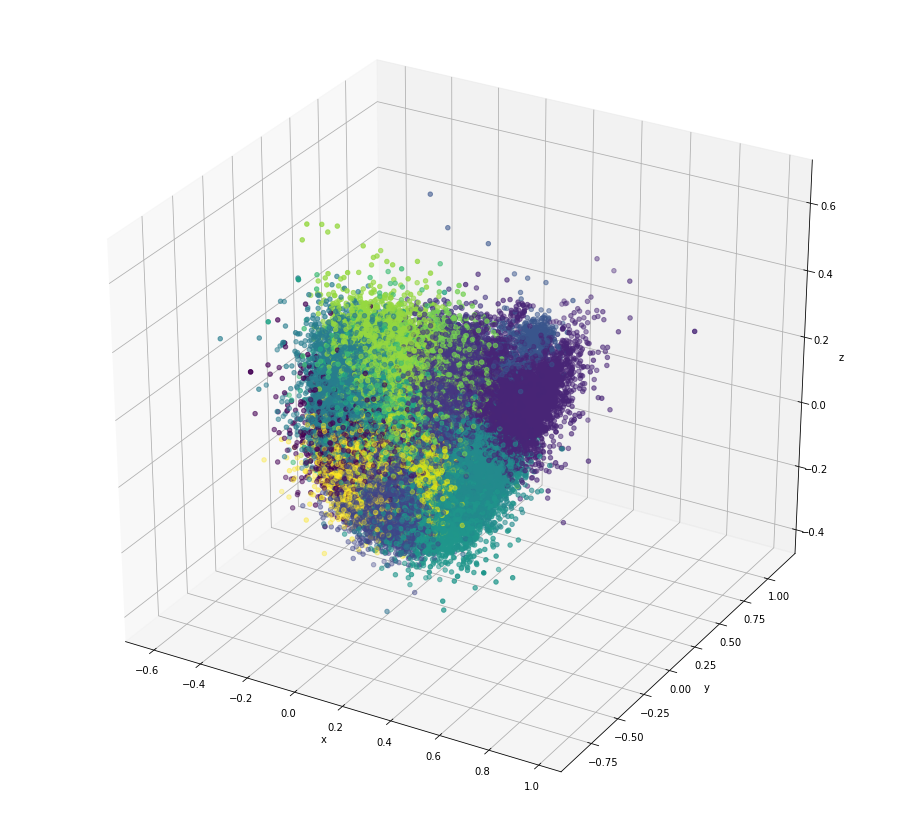

In [ ]:
plt.figure(figsize=(16,15))
axes = plt.axes(projection='3d')
axes.scatter3D(X_pca[0], X_pca[1], X_pca[2], c = predictions)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
plt.show()

##Разметка данных и отбор эталонных объектов в кластерах

На основе выделенных данных мы разметили наши статьи. Так как по графикам выше видно, что центроиды многих кластеров расположены близко к друг другу, определение точек на границах кластеров может быть неоднозначным. Для того чтобы убрать эту неопределенность при обучении модели классификации, было принято решение отобрать эталонные объекты, т.е. точки ближайшие к центроидам. Мы пробовали два подхода: 1) отобрать конкретное число точек, например, 1000 в кластере; 2) отобрать какой-то процент N ближайших точек в кластере. 

Второй подход для 20% процентов дал хорошие результаты, которые мы сдесь опишем.



In [ ]:
import dill
with open('/content/drive/MyDrive/MADE/data/clusters/knn_20_model.pkl', 'rb') as file:
  km = dill.load(file)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
centroids = km.cluster_centers_
N = 20 # (%)
etalon_idx = []
for class_i, centr in enumerate(centroids): 
  df_i = pand_df[pand_df['n_cluster'] == class_i]
  dist_vect = euclidean_distances(centr.reshape(1, -1), df_i.drop(labels = ['n_cluster'], axis = 1))
  temp = [(df_i.index[i], dist_vect[0][i]) for i in range(len(dist_vect[0]))]
  temp.sort(key=lambda x: x[1])
  n_min = max(df_i.shape[0] * N // 100, 500)
  etalon_idx = etalon_idx + [t[0] for t in temp[:n_min]]


In [ ]:
X_etalon = df.iloc[etalon_idx]
X_etalon


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,n_cluster
45028,0.150713,-0.060851,0.165948,-0.254740,0.040761,0.144034,-0.131143,-0.051714,0.093291,-0.010760,...,-0.100247,-0.062951,0.067596,-0.021361,0.000537,-0.213895,0.008185,-0.079202,-0.138174,0
486862,0.139182,-0.067318,0.163542,-0.249415,0.031703,0.156306,-0.132377,-0.043352,0.085096,0.017420,...,-0.088050,-0.094898,0.047492,-0.005657,0.015138,-0.210294,-0.018708,-0.088134,-0.127648,0
339530,0.153701,-0.069930,0.179013,-0.252091,0.018629,0.146098,-0.145079,-0.044205,0.083381,0.016330,...,-0.091463,-0.070641,0.057054,-0.006098,-0.011757,-0.211894,-0.016490,-0.111326,-0.133477,0
334670,0.148873,-0.121028,0.178643,-0.267882,0.022375,0.145200,-0.146483,-0.042603,0.060577,0.019733,...,-0.087070,-0.091165,0.056406,0.014358,0.023641,-0.202593,-0.003354,-0.073428,-0.133436,0
262839,0.108760,-0.084511,0.158591,-0.260177,0.007824,0.143997,-0.136189,-0.077793,0.074191,0.000019,...,-0.079571,-0.056417,0.055113,0.012510,0.007361,-0.192364,-0.005270,-0.062630,-0.129576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521557,0.147621,-0.066073,0.134007,-0.233441,0.057823,0.148281,-0.109650,-0.045241,0.081695,0.000191,...,-0.096848,-0.076632,0.018925,-0.019570,0.001596,-0.227634,-0.021021,-0.088721,-0.160552,19
387272,0.124359,-0.069172,0.156823,-0.218283,0.046950,0.127221,-0.077272,-0.055221,0.019914,0.021064,...,-0.078004,-0.104973,0.058803,-0.000741,0.010910,-0.209361,-0.030189,-0.093741,-0.131156,19
26874,0.119424,-0.074165,0.145723,-0.218180,0.034252,0.187163,-0.145849,-0.029469,0.053078,0.025711,...,-0.093120,-0.092628,0.002413,0.017519,0.012017,-0.190740,0.000105,-0.123312,-0.139087,19
597860,0.144670,-0.070275,0.188724,-0.253439,0.032336,0.153360,-0.133689,-0.027773,0.041479,0.027975,...,-0.074923,-0.089749,0.045108,0.012896,0.025980,-0.160379,-0.023333,-0.105053,-0.154216,19


In [ ]:
stat1 = X_etalon.groupby(['n_cluster']).count()
stat1.iloc[:, 0]

n_cluster
0      7600
1       500
2      8875
3      7267
4      2811
5      6461
6      6887
7      7509
8      3828
9      2265
10     8436
11     7178
12     5935
13    11064
14     5970
15     2776
16     4260
17     8403
18     6974
19    10079
Name: 0, dtype: int64

Отобранные эталонные объекты использовались для обучения и тестирвания моделей. А оставшиеся "неэталонные" объекты использовались для дополнительной проверки моделей.

## Обучение моделей классификации научных статей

Эталонные объекты были разбиты на трэйн и тэст подвыборки в соотношении 70% к 30%.

Были обучены следующие модели (с разными параметрами):
```
1. SGDClassifier(random_state=10, max_iter=100)
2. XGBClassifier(n_estimators = 50, objective="multi:softmax")
3. RandomForestClassifier(max_depth=5, random_state=0)
4.  CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           depth=5,
                           loss_function='MultiClass')


```



**Тестирование моделей и оценка на неэталонных объектах**

Для этих моделей были получены следующие результаты:

```
model      avr.acc      avr.acc     avr.acc
           (train)       (test)   (non-etalon)

SGD           0.83        0.82       0.64
XGBoost       0.96        0.88       0.66
RandomForest  0.74        0.72       0.48
CatBoost      0.96        0.91       0.84


```

Видим, что CatBoost показал точность 84% даже на неэталонных объектах, т.е. эта модель позволяет достаточно корректно классифицировать пограничные объекты.



## Выделение тэгов в классах

После того как мы спрогнозировали классы статей с помощью модели CatBoost, мы можем найти самые популярные области исследований в каждом классе (признак fos в данных). 

Мы сгрупировали наши исходные данные (поле fos) и данные с предсказаными классами по полю '_id' в таблицу res. И нашли самые популярные fos в каждом классе. В некоторых статьях  число значений fos может превышать 10, то мы отбирали максимум  4 первых значения, которые наиболее характеризуют статью.  

In [ ]:
from collections import Counter

def first_four(f_list):
  result = []
  for i, f in enumerate(f_list):
    result.append(f)
    if i == 3:
      break
  return result

class_tags = []
for cl in range(20):
  
  class_fos = list(res[res['label'] == cl].dropna().fos)
  fos_list = np.hstack(map(first_four, class_fos))
  class_tags.append(Counter(fos_list).most_common(20))

for i, item in enumerate(class_tags):
  print(f'class {i}, tags: {item}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


class 0, tags: [('Computer science', 25494), ('Software engineering', 5161), ('Programming language', 3360), ('Architecture', 2586), ('Computer architecture', 2433), ('Systems engineering', 2192), ('Data mining', 1199), ('Control theory', 1179), ('World Wide Web', 1130), ('Scheduling (computing)', 1084), ('Simulation', 984), ('Computer vision', 941), ('Parallel computing', 927), ('Middleware', 920), ('Virtual machine', 895), ('Object-oriented programming', 798), ('Software deployment', 727), ('Mathematical optimization', 712), ('Grid computing', 683), ('Software design', 676)]
class 1, tags: [('Computer science', 178), ('Humanities', 161), ('Political science', 124), ('Signal processing', 75), ('Speech processing', 53), ('Algorithm', 46), ('Mathematical optimization', 33), ('Combinatorics', 33), ('Discrete mathematics', 31), ('Gynecology', 30), ('Philosophy', 28), ('Speech recognition', 26), ('Applied mathematics', 23), ('Computer vision', 21), ('Art', 19), ('Control theory', 19), ('Sp

Видно, что практически в каждом классе самый популярный fos это Computer science, это говорит о том, что исследуемая база статей имеет одно общее широкое направление, которое мы выбросим из тэгов.  

Построим графики распределния fos(без Computer science) по классам, чтобы понять какая отрасль характеризует каждый класс.

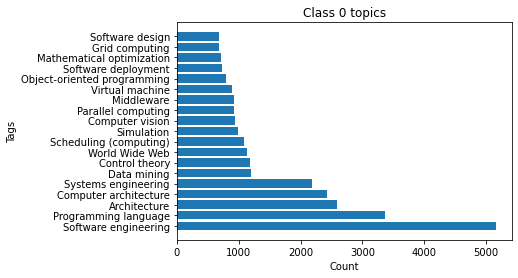

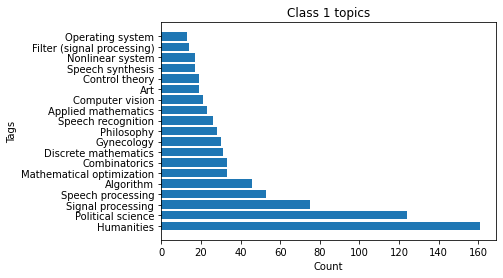

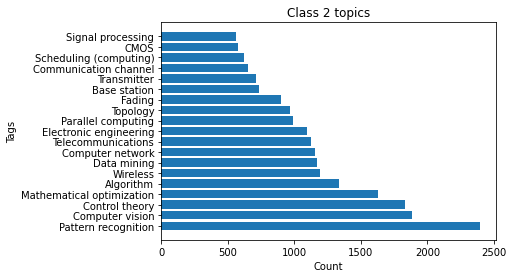

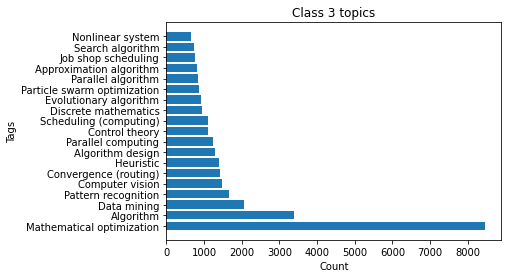

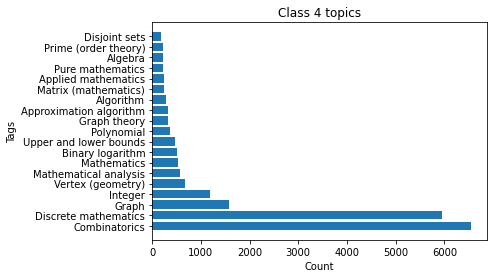

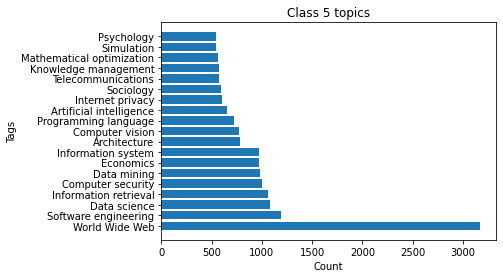

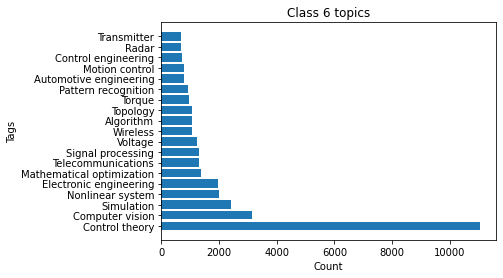

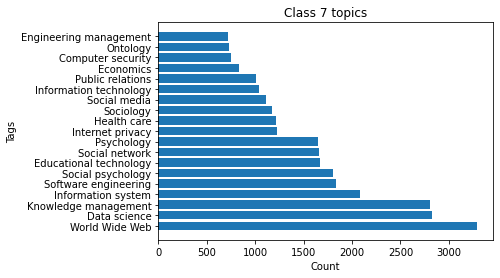

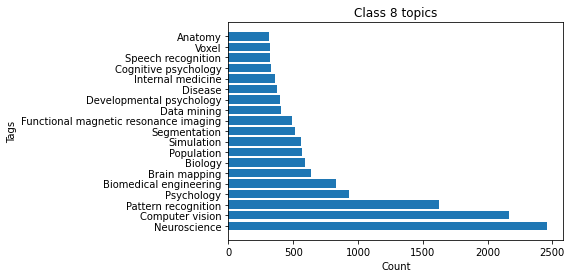

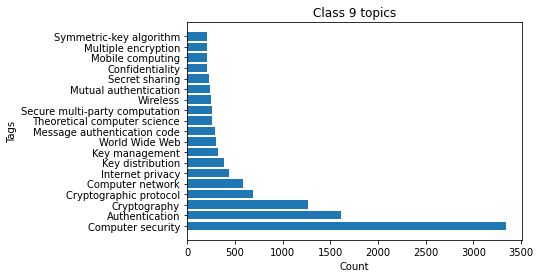

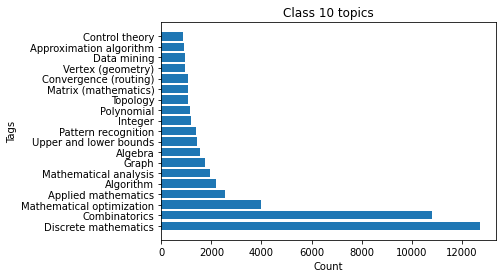

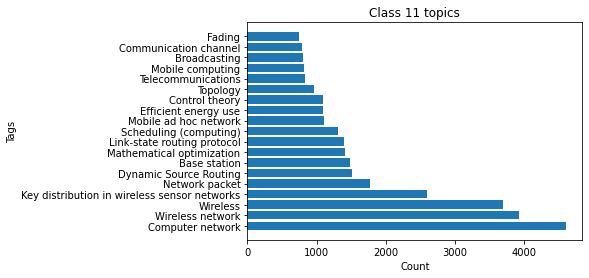

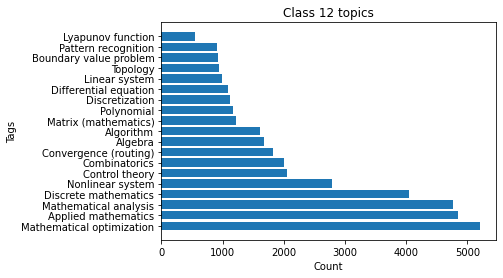

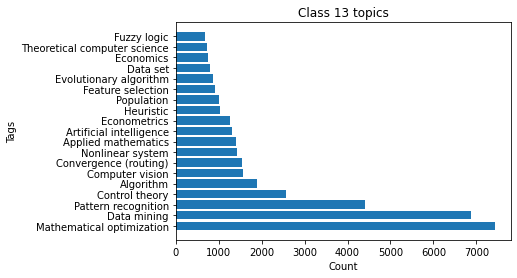

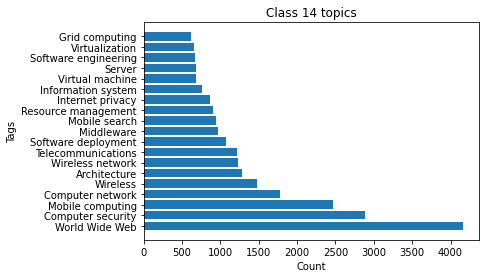

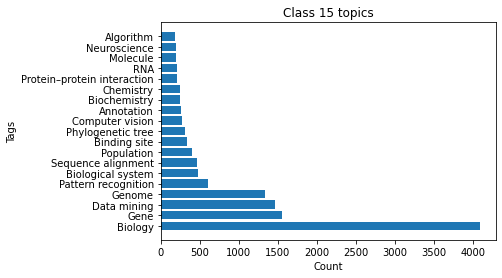

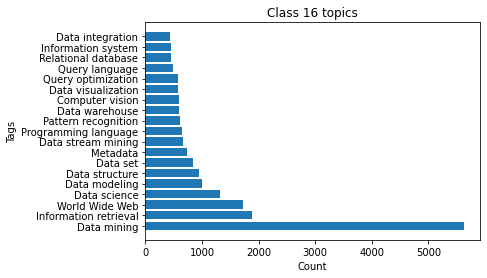

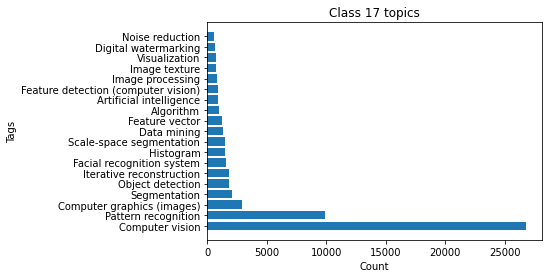

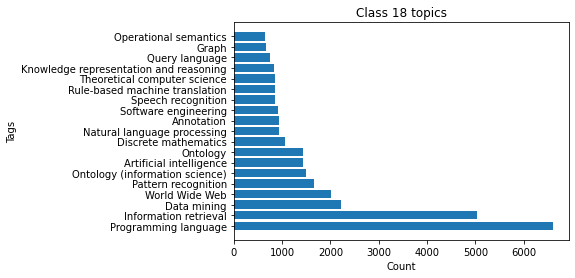

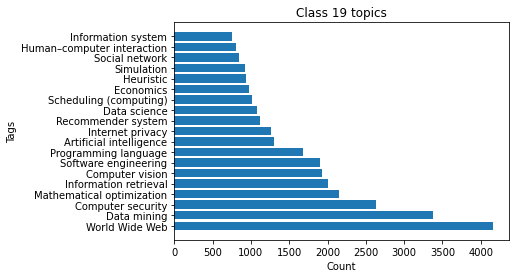

In [ ]:
def plot_hist(n_class):
  import matplotlib.pyplot as plt

  cl = class_tags[n_class]
  cl_dict = {}
  for item in cl:
      cl_dict[item[0]] = item[1]
  cl_dict.pop('Computer science')
  x = list(cl_dict.values())
  y = list(cl_dict.keys())
  plt.barh(y, x)
  plt.ylabel("Tags")
  plt.xlabel("Count")
  plt.title(f'Class {n_class} topics')
  plt.show()
  
for cl in range(20):
  plot_hist(cl)


Окончательно выделяем следующие тэги для классов:
```
0 - Software engineering/Programming language
1 - Humanities
2 - Computer Vision and Pattern Recognition/Networking and Internet Architecture
3 - Mathematical optimization
4 - Discrete Mathematics/Graph
5 - Networking and Internet Architecture
6 - Control theory
7 - Social and Information Networks
8 - Neuroscience
9 - Cryptography and Security
10 - Discrete Mathematics/Optimization
11 - Computer network
12 - Mathematics of Computing
13 - Mathematics of Data mining
14 - Mobile computing
15 - Biology
16 - Data science
17 - Computer vision
18 - Information retrieval
19 - Data Web security
```
